In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from selenobot.files import XMLFile
from selenobot.utils import seed 
from selenobot.datasets import Dataset, get_dataloader
from selenobot.utils import digitize, groupby, sample
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from selenobot.tools import Clusterer
from tqdm import tqdm

sys.path.append('../scripts/')
from build import clean, process

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_length_distribution(metadata_dfs:List[pd.DataFrame], ax:plt.Axes=None, bins:int=25, density:bool=False):

    n_dropped, lengths = 0, []
    for df in metadata_dfs:
        nans = df.seq.isnull()
        n_dropped += nans.sum()
        lengths.append(df[~nans].seq.apply(len).values)
    print(f'plot_length_distribution: Dropped {n_dropped} empty sequences.')

    ax.hist(lengths, density=density, bins=bins, edgecolor='white')
    ax.set_ylabel('density' if density else 'count')
    ax.set_xlabel('length')


In [19]:
def truncate_non_sec(df:pd.DataFrame, uniprot_sec_df:pd.DataFrame=None, n_bins:int=10, bandwidth:float=0.01, **kwargs) -> pd.DataFrame:

    sec_lengths = uniprot_sec_df.seq.apply(len)
    sec_truncation_ratios = uniprot_sec_df.truncation_ratio.values

    # Group the lengths of the full-length selenoproteins into n_bins bins
    hist, bin_edges = np.histogram(sec_lengths, bins=n_bins)
    bin_labels, bin_names = digitize(sec_lengths, bin_edges)

    # Sample from the DataFrame of full-length SwissProt proteins, ensuring that the length distribution matches
    # that of the full-length selenoproteins. 
    _, idxs = sample(df.seq.apply(len).values, hist, bin_edges)
    # Assign each of the sampled proteins a bin label, where the bins are the same as those of the full-length selenoprotein
    # length distribution (from above).
    df = df.iloc[idxs].copy()
    df['bin_label'], _ = digitize(df.seq.apply(len).values, bin_edges)

    # Generate a continuous distribution for truncation ratios for each length bin. This is necessary because of 
    # heteroscedacity: the variance in the truncation ratios of short sequences is much higher than that of long
    # sequences, so need to generate different distributions for different length categories. 
    kdes = dict()

    pbar = tqdm(total=len(np.unique(bin_labels)), desc='truncate_non_sec: Generating KDEs of length bins...')
    for bin_label, bin_values in groupby(sec_truncation_ratios, bin_labels).items():
        # print(f'truncate_non_sec: Fitting KDE for length bin {bin_label}.')
        kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=bandwidth) 
        kde.fit(bin_values.reshape(-1, 1))
        kdes[bin_label] = kde
        pbar.update(1)
    pbar.close()

    # Use the KDE to sample truncation ratios for each length bin, and apply the truncation to the full-length sequence. 
    df_truncated = []
    pbar = tqdm(total=len(df), desc='truncate_non_sec: Sampling truncation sizes from KDEs...')
    for bin_label, bin_df in df.groupby('bin_label'):
        bin_df['truncation_size'] = kdes[bin_label].sample(n_samples=len(bin_df), random_state=42).ravel() * bin_df.seq.apply(len).values
        bin_df['truncation_size'] = bin_df.truncation_size.astype(int)
        bin_df['original_length'] = bin_df.seq.apply(len)
        bin_df['seq'] = bin_df.apply(lambda row : row.seq[:-row.truncation_size], axis=1)
        df_truncated.append(bin_df)
        pbar.update(len(bin_df))
    pbar.close()

    df_truncated = pd.concat(df_truncated).drop(columns=['bin_label'])
    df_truncated.index.name = 'id'
    df_truncated.index = [id_ + '-' for id_ in df_truncated.index]

    return df_truncated

In [3]:
uniprot_sprot_df = clean(pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sprot.csv'), index_col=0), allow_c_terminal_fragments=True, remove_selenoproteins=False)
uniprot_sec_df = clean(pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sec.csv'), index_col=0), allow_c_terminal_fragments=False, remove_selenoproteins=False)

clusterer = Clusterer(name='uniprot_sec', cwd='./out', tool='mmseqs')
uniprot_sec_df = clusterer.dereplicate(uniprot_sec_df, overwrite=False)
uniprot_sec_df['seq_truncated'] = uniprot_sec_df.seq.apply(lambda s : s[:s.index('U')])
uniprot_sec_df['truncation_ratio'] = (uniprot_sec_df.seq.apply(len) - uniprot_sec_df.seq_truncated.apply(len)) / uniprot_sec_df.seq.apply(len)

clean: Removed 235396 non-bacterial proteins from the DataFrame. 336468 sequences remaining.
clean: Removed 140 proteins which exceed 2000 amino acids in length from the DataFrame. 336328 sequences remaining.
clean: Removed 699 fragment proteins from the DataFrame. 335629 sequences remaining.
clean: Removed 3216 non-bacterial proteins from the DataFrame. 16412 sequences remaining.
clean: Removed 0 proteins which exceed 2000 amino acids in length from the DataFrame. 16412 sequences remaining.
clean: Removed 958 fragment proteins from the DataFrame. 15454 sequences remaining.
mmseqs easy-cluster ./out/uniprot_sec.fa ./out/dereplicate_uniprot_sec ./out/tmp --min-seq-id 0.95
Clusterer.dereplicate: Dereplication of clusters with 0.95 similarity eliminated 4412 sequences from uniprot_sec. 11042 sequences remaining.


In [21]:
uniprot_sprot_sample_df = truncate_non_sec(uniprot_sprot_df, uniprot_sec_df=uniprot_sec_df)

truncate_non_sec: Generating KDEs of length bins...: 100%|██████████| 10/10 [00:00<00:00, 3385.78it/s]
truncate_non_sec: Sampling truncation sizes from KDEs...: 100%|██████████| 20688/20688 [00:00<00:00, 133353.87it/s]


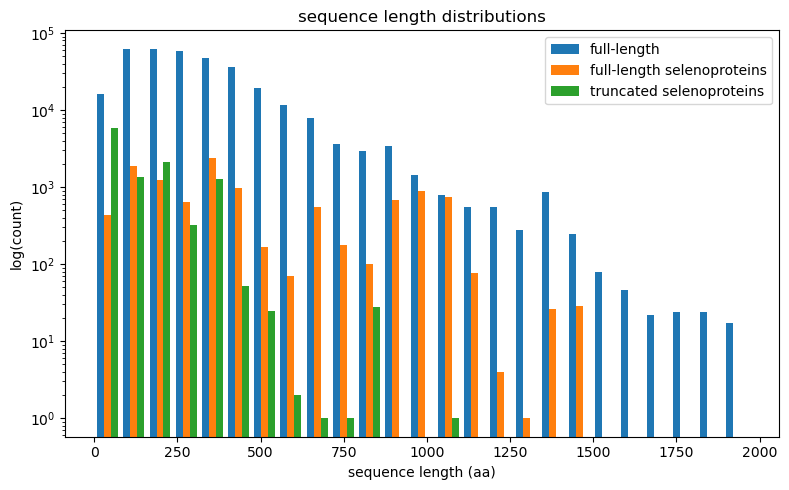

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist((uniprot_sprot_df.seq.apply(len), uniprot_sec_df.seq.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
ax.set_yscale('log')
ax.legend(['full-length', 'full-length selenoproteins', 'truncated selenoproteins'])
ax.set_title('sequence length distributions')
ax.set_ylabel('log(count)')
ax.set_xlabel('sequence length (aa)')

plt.tight_layout()
plt.show()

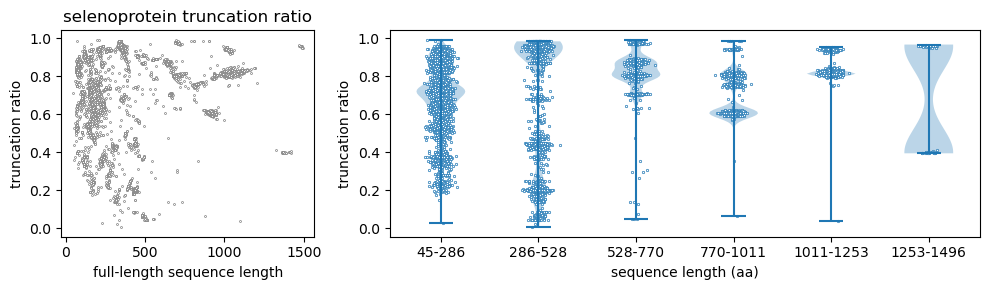

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), width_ratios=[0.3, 0.7])

axes[0].set_xlabel('full-length sequence length')
axes[0].set_ylabel('truncation ratio')
axes[0].set_title('selenoprotein truncation ratio')
x = uniprot_sec_df.seq.apply(len)
y = (uniprot_sec_df.seq.apply(len) - uniprot_sec_df.seq_truncated.apply(len)) / uniprot_sec_df.seq.apply(len) 
axes[0].scatter(x, y, s=2, facecolor='white', linewidth=0.5, edgecolor='gray')

# TODO: https://towardsdatascience.com/kernel-density-estimation-explained-step-by-step-7cc5b5bc4517 
# TODO: https://stackoverflow.com/questions/3510475/generate-random-numbers-according-to-distributions 

n_bins = 6
hist, bin_edges = np.histogram(uniprot_sec_df.seq.apply(len).values, bins=n_bins)
bin_labels, bin_names = digitize(uniprot_sec_df.seq.apply(len).values, bin_edges)
binned_ratios = groupby(uniprot_sec_df.truncation_ratio.values, bin_labels)

data = [np.sort(binned_ratios[bin_label]) for bin_label in range(1, n_bins + 1)]
axes[1].violinplot(data, orientation='vertical')
for bin_label, ratios in binned_ratios.items():
    x_values = np.array([bin_label] * len(ratios))
    offsets = np.random.normal(size=len(ratios), scale=0.05)
    axes[1].scatter(x_values + offsets, ratios, color='tab:blue', s=3, facecolor='white', linewidth=0.5)
axes[1].set_xticks(np.arange(n_bins) + 1, bin_names)
axes[1].set_xlabel('sequence length (aa)')
axes[1].set_ylabel('truncation ratio')

plt.tight_layout()
plt.show()

# NOTE: There appears to be very little correlation between length of the original sequence and the amount of the
# sequence which is truncated. However, it is pretty clear that the data are heteroscedastic. To properly reproduce the 
# distribution, I am going to try binning by length first. 

In [17]:
def truncate(df:pd.DataFrame, sec_seqs:np.ndarray, n_bins:int=25, bandwidth:float=0.01) -> pd.DataFrame:
    '''Sub-sample the set of all full-length proteins such that the length distribution matches that of the full-length
    selenoproteins. Then, truncate the sampled sequences so that the truncated length distributions also match.

    :param df: The DataFrame containing the complete set of SwissProt proteins. 
    :param n_bins: The number of bins to use for producing a length distribution of full-length selenoproteins. 
        This is used when initially down-sampling SwissProt. 
    :param bandwidth: The bandwidth to use for the kernel density estimation, which is used for creating 
        distributions for selecting truncation ratios. 
    :return: A pandas DataFrame containing the sub-sampled and randomly truncated SwissProt proteins. 
    '''
    sec_seqs_truncated = np.array([seq.split('U')[0] for seq in sec_seqs])
    sec_lengths = np.array([len(seq) for seq in sec_seqs])
    sec_lengths_truncated = np.array([len(seq) for seq in sec_seqs_truncated]) 

    sec_truncation_ratios = (sec_lengths - sec_lengths_truncated) / sec_lengths

    hist, bin_edges = np.histogram(sec_lengths, bins=n_bins)
    bin_labels, bin_names = digitize(sec_lengths, bin_edges)

    _, idxs = sample(df.seq.apply(len).values, hist, bin_edges)
    df = df.iloc[idxs].copy()
    df['bin_label'], _ = digitize(df.seq.apply(len).values, bin_edges)

    kdes = dict()
    for bin_label, bin_values in groupby(sec_truncation_ratios, bin_labels).items():
        kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=bandwidth) 
        kde.fit(bin_values.reshape(-1, 1))
        kdes[bin_label] = kde

    df_truncated = []
    for bin_label, bin_df in df.groupby('bin_label'):
        bin_df['truncation_size'] = kdes[bin_label].sample(n_samples=len(bin_df)).ravel() * bin_df.seq.apply(len).values
        bin_df['original_length'] = bin_df.seq.apply(len)
        bin_df['seq'] = bin_df.apply(lambda row : row.seq[:-int(row.truncation_size)], axis=1)
        df_truncated.append(bin_df)

    return pd.concat(df_truncated)

Dataset.sampler: 541188 samples required for dataset coverage.
Number of batches: 33825


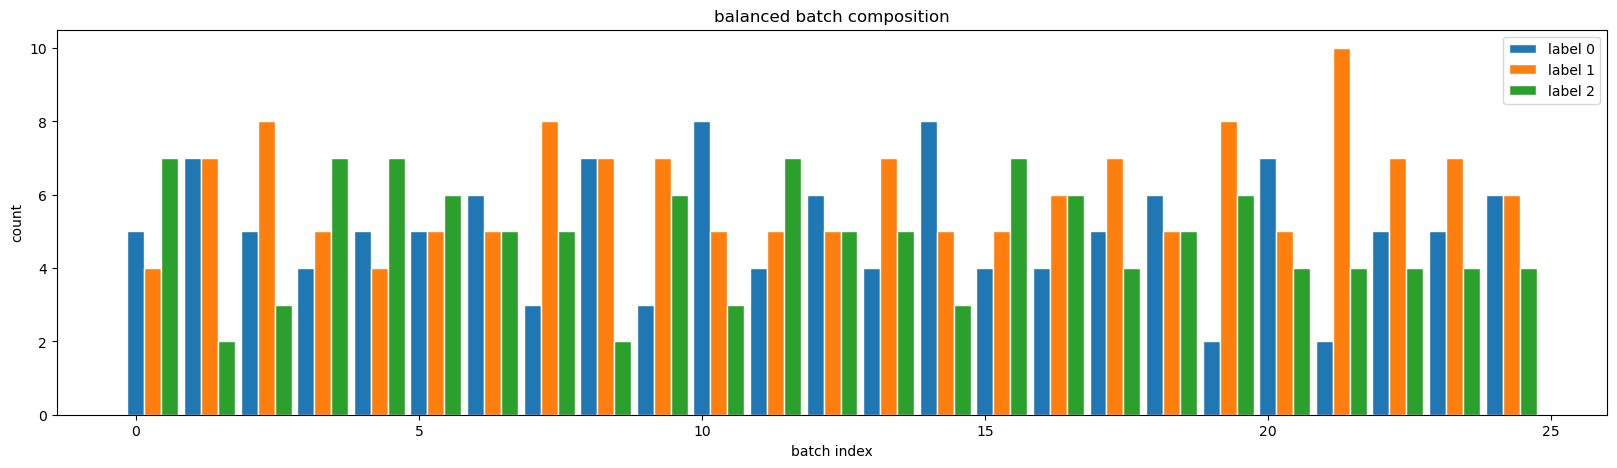

Total with label 0: 126
Total with label 1: 153
Total with label 2: 121


In [22]:
dataset = Dataset.from_hdf('../data/test.h5', feature_type='len', n_classes=3)
dataloader = get_dataloader(dataset, batch_size=16, balance_batches=True)

fig, ax = plt.subplots(figsize=(20, 5))

n_batches = len(dataloader)
show_n = 25 # Number of batches to display on the plot. 

print('Number of batches:', n_batches)
counts = {label:[] for label in range(3)}

n = 0
for batch in dataloader:
    n += 1
    labels = batch['label'].numpy()
    assert len(labels) == 16, 'The batch size is not what was specified.'
    for label in range(3):
        counts[label].append((labels == label).sum())
    if n == show_n:
        break

bar_width = 0.3
bar_positions = np.arange(show_n)

ax.bar(bar_positions, counts[0], width=bar_width, edgecolor='w', linewidth=1)
ax.bar(bar_positions + bar_width, counts[1], width=bar_width, edgecolor='w', linewidth=1)
ax.bar(bar_positions + bar_width * 2, counts[2], width=bar_width, edgecolor='w', linewidth=1)

ax.legend([f'label {label}' for label in range(3)])
ax.set_title('balanced batch composition')
ax.set_ylabel('count')
ax.set_xlabel('batch index')

plt.show()

# What are the totals?
for label, batch_counts in counts.items():
    print(f'Total with label {label}:', sum(batch_counts))



In [ ]:
# Another thing which is worth checking is if the random seeding worked. In other words, do repeated calls to the balanced
# batch sampler result in the same batches (I am hoping this is the case, as I seeded all the RNGs). 

dataset = Dataset.from_hdf('../data/test.h5', feature_type='len', n_classes=3).subset(0, 1000)

seed(42)
dataloader = get_dataloader(dataset, batch_size=16, balance_batches=True)
ref_ids =np.concat([batch['id'] for batch in dataloader]).ravel()

for _ in range(3):
    seed(42)
    dataloader = get_dataloader(dataset, batch_size=16, balance_batches=True)
    ids = np.concat([batch['id'] for batch in dataloader]).ravel()
    assert np.all(ids == ref_ids), 'Generated batches do not match.'

# Ok good, so it does seem as though the batches are consistent. 

Dataset.sampler: 12660 samples required for dataset coverage.
Dataset.sampler: 12660 samples required for dataset coverage.
Dataset.sampler: 12660 samples required for dataset coverage.
Dataset.sampler: 12660 samples required for dataset coverage.


In [91]:
# Want to take a look at the datasets a bit. Especially because of the weird behavior I am seeing with performance on the test set
# being substantially higher for binary classifiers. 

train_metadata_df = pd.read_csv('../data/train.csv', index_col=0)
train_metadata_df = train_metadata_df[train_metadata_df.label.isin([0, 1])]

test_metadata_df = pd.read_csv('../data/test.csv', index_col=0)
test_metadata_df = test_metadata_df[test_metadata_df.label.isin([0, 1])]

val_metadata_df = pd.read_csv('../data/val.csv', index_col=0)
val_metadata_df = val_metadata_df[val_metadata_df.label.isin([0, 1])]  

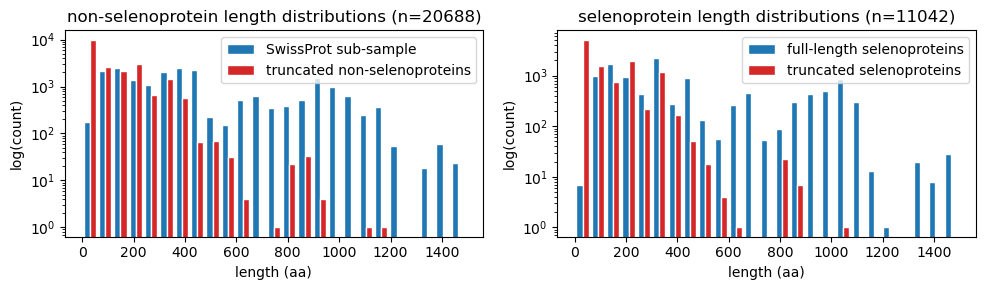

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].hist((uniprot_sprot_sample_df.original_length, uniprot_sprot_sample_df.seq.apply(len)), bins=25, edgecolor='white', color=['tab:blue', 'tab:red'])
# axes[0].hist((uniprot_sprot_sample_df.seq.apply(len), uniprot_sprot_sample_df.seq_truncated.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
axes[0].set_yscale('log')
axes[0].set_ylabel('log(count)')
axes[0].set_xlabel('length (aa)')
axes[0].legend(['SwissProt sub-sample', 'truncated non-selenoproteins'])
axes[0].set_title(f'non-selenoprotein length distributions (n={len(uniprot_sprot_sample_df)})')

axes[1].hist((uniprot_sec_df.seq.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25, edgecolor='white', color=['tab:blue', 'tab:red'])
# axes[0].hist((uniprot_sprot_sample_df.seq.apply(len), uniprot_sprot_sample_df.seq_truncated.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
axes[1].set_yscale('log')
axes[1].set_ylabel('log(count)')
axes[1].set_xlabel('length (aa)')
axes[1].legend(['full-length selenoproteins', 'truncated selenoproteins'])
axes[1].set_title(f'selenoprotein length distributions (n={len(uniprot_sec_df)})')

plt.tight_layout()
plt.show()

In [11]:
# # API URL for retrieving bacterial proteins which are non-TrEMBL reviewed, and have evidence at the transcript level. 
# # See this link for more info on protein existence: https://www.uniprot.org/help/protein_existence
# # https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=xml&query=%28%28taxonomy_id%3A2%29%29+AND+%28reviewed%3Afalse%29+AND+%28existence%3A2%29

# xml_file = NcbiXmlFile(os.path.join(DATA_DIR, 'uniprot_trembl.xml'))
# xml_file.to_df().to_csv(os.path.join(DATA_DIR, 'uniprot_trembl.csv'))

In [61]:
train_metadata_df = pd.read_csv('../data/train.csv', index_col=0)
test_metadata_df = pd.read_csv('../data/test.csv', index_col=0)
val_metadata_df = pd.read_csv('../data/val.csv', index_col=0)

metadata_df = pd.concat([train_metadata_df, test_metadata_df, val_metadata_df])

plot_length_distribution: Dropped 5 empty sequences.


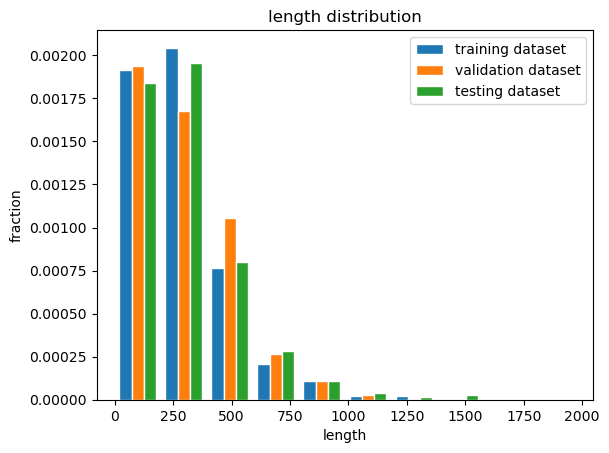

In [62]:
fig, ax = plt.subplots()
plot_length_distribution([train_metadata_df, val_metadata_df, test_metadata_df], ax=ax, bins=10)
ax.legend(['training dataset', 'validation dataset', 'testing dataset'])
plt.show()

In [63]:
levels = ['domain', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

N = len(metadata_df)
print('Total number of sequences:', N)

for level in levels:
    n = np.sum(~metadata_df[level].isnull())
    print(f'Number of sequences assigned a {level}:', n, f'({int((n / N) * 100)}%)')

Total number of sequences: 221239
Number of sequences assigned a domain: 221239 (100%)
Number of sequences assigned a kingdom: 221097 (99%)
Number of sequences assigned a phylum: 218287 (98%)
Number of sequences assigned a class: 216329 (97%)
Number of sequences assigned a order: 215381 (97%)
Number of sequences assigned a family: 209468 (94%)
Number of sequences assigned a genus: 31835 (14%)
Number of sequences assigned a species: 221239 (100%)


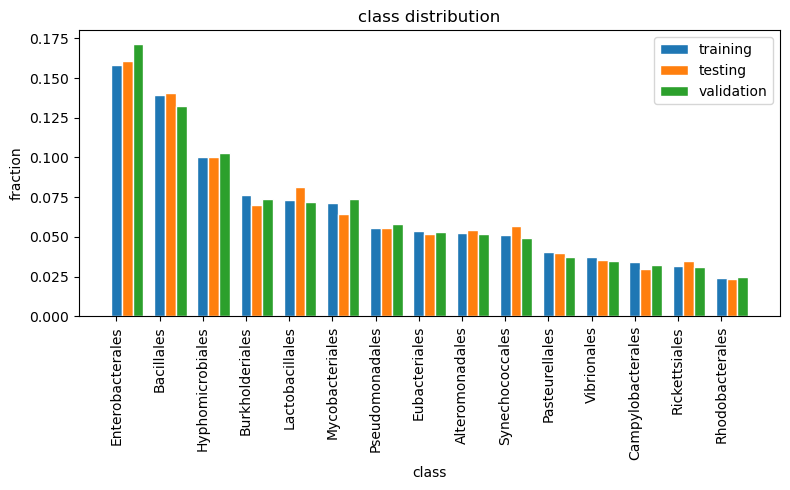

In [64]:
def plot_taxonomy_distribution(metadata_dfs:List[pd.DataFrame], level:str='class', title:str=None, taxa:List[str]=None, ax:plt.Axes=None, set_xlabel:bool=True):

    bar_width = 1 / (len(metadata_dfs) + 1)

    for i, metadata_df in enumerate(metadata_dfs):
        data = metadata_df.groupby(level).apply(len) 
        n = len(taxa) # Number of taxa to display. 
        n_total = len(data)
        heights = np.array([data.loc[t].item() if (t in data.index) else 0 for t in taxa])
        ax.bar(np.arange(n) + (i * bar_width), heights / heights.sum() , bar_width, edgecolor='white')

    ax.set_xticks(np.arange(n), labels=taxa, rotation=90)
    title = f'{level} distribution' if title is None else title
    
    ax.set_title(title)
    ax.set_ylabel('fraction')
    if set_xlabel:
        ax.set_xlabel(level)

    if len(metadata_dfs) == 1:
        inset_ax = ax.inset_axes([0.6, 0.3, 0.3, 0.7])
        n_shown = data[data.index.isin(taxa)].sum()
        n_remain = data[~data.index.isin(taxa)].sum()
        n_total = data.sum()
        inset_ax.pie([n_shown, n_remain], labels=[f'{int(100 * n_shown / n_total)} %', f'{int(100 * n_remain / n_total)} %'])

    plt.tight_layout()

fig, ax = plt.subplots(figsize=(8, 5))

top_taxa = metadata_df.groupby('class').apply(len).sort_values(ascending=False).index.values[:15]
plot_taxonomy_distribution([train_metadata_df, test_metadata_df, val_metadata_df], ax=ax, taxa=top_taxa)
ax.legend(['training', 'testing', 'validation'])


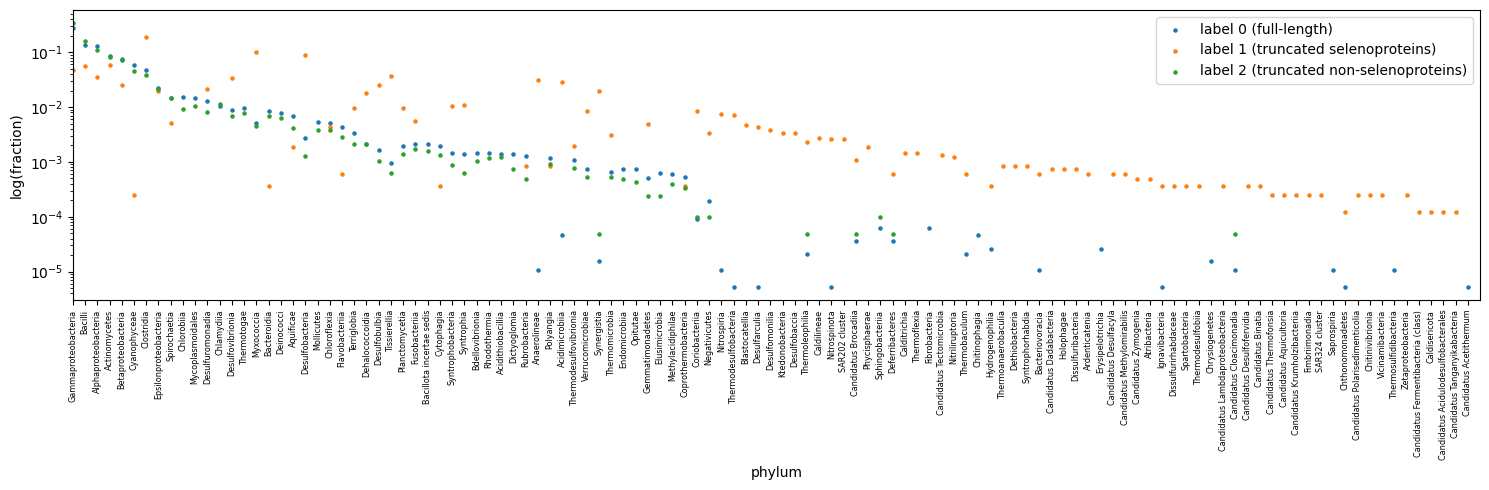

In [90]:
fig, ax = plt.subplots(figsize=(15, 5))

level = 'phylum'
top_taxa = metadata_df.groupby(level).apply(len).sort_values(ascending=False).index.values
n = len(top_taxa)

for label in [0, 1, 2]:
    y_values = metadata_df[metadata_df.label == label].groupby(level).apply(len).sort_values(ascending=False)
    y_values = y_values / y_values.sum() # Normalize according to dataset size. 
    y_values = y_values.reindex(top_taxa).fillna(0) # Standardize the order. 
    ax.scatter(np.arange(n), y_values.values, s=5)

ax.legend(['label 0 (full-length)', 'label 1 (truncated selenoproteins)', 'label 2 (truncated non-selenoproteins)'])
ax.set_yscale('log')
ax.set_xticks(np.arange(n), labels=top_taxa, rotation=90, fontsize='xx-small')
ax.set_xlim(0, n)
ax.set_ylabel('log(fraction)')
ax.set_xlabel(level)

plt.tight_layout()
plt.show()
